In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import seaborn as sns
pd.set_option('display.max_columns', None)
import os
import chart_studio.plotly as py
# import plotly.graph_ogjs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

In [2]:
#Importing the data
final_df=pd.DataFrame()
a_df=pd.DataFrame()
b_df=pd.DataFrame()
c_df=pd.DataFrame()

for file_n in os.listdir('listings'):
    if file_n[0]=='.':
        continue
    else:
        add_df = pd.read_csv(f'listings/{file_n}')
        if len(add_df.columns)==106:
            final_df = pd.concat([final_df, add_df], axis=0)
        elif len(add_df.columns)==96:
            a_df = pd.concat([a_df, add_df], axis=0)
        elif len(add_df.columns)==95:
            b_df = pd.concat([b_df, add_df], axis=0)
        else:
            c_df = pd.concat([c_df, add_df], axis=0)

/Users/sherryduong/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning:

Columns (43) have mixed types. Specify dtype option on import or set low_memory=False.

/Users/sherryduong/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning:

Columns (61,62) have mixed types. Specify dtype option on import or set low_memory=False.

/Users/sherryduong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




In [16]:
#These are the columns not present in 2018 reports. They will be dropped.
not_in_2018 = ['minimum_minimum_nights','maximum_minimum_nights','minimum_maximum_nights','maximum_maximum_nights',
       'minimum_nights_avg_ntm','maximum_nights_avg_ntm', 'number_of_reviews_ltm', 
       'calculated_host_listings_count_entire_homes','calculated_host_listings_count_private_rooms', 
       'calculated_host_listings_count_shared_rooms']
sf_df = final_df.drop(columns=not_in_2018)
sf_df = pd.concat([sf_df, a_df], axis=0)

#drop one column not in 2017
sf_df = sf_df.drop(columns=['is_business_travel_ready'])
sf_df = pd.concat([sf_df, b_df], axis=0)

#drop 3 columns not in 2016 & Prior
sf_df = sf_df.drop(columns=['access', 'interaction', 'house_rules'])
sf_df = pd.concat([sf_df, c_df], axis=0)

/Users/sherryduong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




## Data Cleaning

In [17]:
pd.set_option('display.max_rows', 20)
#Converting Existing Data Columns to Dates
sf_df['last_scraped'] = pd.to_datetime(sf_df['last_scraped'])
sf_df['host_since'] = pd.to_datetime(sf_df['host_since'])
#Adding new date features
sf_df['year'] = sf_df['last_scraped'].transform(lambda x: x.year)
sf_df['month-year'] = sf_df['last_scraped'].transform(lambda x: f'{x.month} {x.year}')
sf_df['month'] = sf_df['last_scraped'].transform(lambda x: x.month)
sf_df['day_of_week'] = sf_df['last_scraped'].transform(lambda x: x.dt.dayofweek)
sf_df['day'] = sf_df['last_scraped'].transform(lambda x: x.day)

#Converting All Price Related Columns from Objects to Floats
sf_df['price'] = sf_df['price'].transform(lambda x: float(x.replace(',', '').replace('$', '')))
sf_df['extra_people'] = sf_df['extra_people'].transform(lambda x: float(x.replace(',', '').replace('$', '')))

#Fill NaNs in fee columns with 0's, because no additional fee, then convert
sf_df[['security_deposit','cleaning_fee']] = sf_df[['security_deposit','cleaning_fee']].fillna(int(0))
sf_df['security_deposit'] = sf_df['security_deposit'].transform(lambda x: 0 if x==int(0) else float(x.replace(',', '').replace('$', '')))
sf_df['cleaning_fee'] = sf_df['cleaning_fee'].transform(lambda x: 0 if x==int(0) else float(x.replace(',', '').replace('$', '')))

#Dropping columns that have over 75% null
over_70_null = sf_df.columns[sf_df.isnull().sum()/len(sf_df) > 0.70]
sf_df = sf_df.drop(columns=over_70_null)

#Removing Outliers (0 & over 2000 daily rate)
outlier_thresh=2000
sf_df = sf_df.loc[~((sf_df['price'] == 0) | (sf_df['price'] > outlier_thresh))]

In [103]:
sf_df['month-year'].nunique()

52

## Train Test Split #1: Use 2015 - 2018 to predict 2019 & 2020

In [48]:
test_years=[2020,2019]
train_df = sf_df[~sf_df['year'].isin(test_years)]
test_df = sf_df[sf_df['year'].isin(test_years)]

In [49]:
#Filling the NaNs in beds, bathrooms, bedrooms
#Assume that if the tenant has the full apartment, they have a bathroom/bedroom
cond1= (train_df['room_type']=='Entire home/apt')
train_df.loc[cond1 & (train_df['beds']==0), train_df.columns=='beds'] = 1
train_df.loc[cond1 & (train_df['bathrooms']==0), train_df.columns=='bathrooms']
#For the rest, just fill na
train_df[['beds','bathrooms', 'bedrooms']] = train_df[['beds','bathrooms', 'bedrooms']].fillna(0)

#For review scores, let's just fillin with the average
review_lst = ['review_scores_accuracy', 'review_scores_checkin',
       'review_scores_cleanliness', 'review_scores_communication',
       'review_scores_location', 'review_scores_rating', 'review_scores_value']
for review in review_lst:
    train_df[review] = train_df[review].fillna(train_df[review].mean())

/Users/sherryduong/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/sherryduong/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3494: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/sherryduong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

## Baseline Models: No Parameter Tuning or Feature Engineering

In [84]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

In [189]:
features=['accommodates','bathrooms', 'bed_type','bedrooms', 'beds','cleaning_fee',
          'extra_people', 'host_response_time',
         'neighbourhood_cleansed','property_type','review_scores_cleanliness',
          'review_scores_rating', 'room_type', 'security_deposit', 'month','day_of_week','year']
X = train_df[features]
y = train_df['price'].apply(np.log)

In [190]:
X = pd.get_dummies(X, columns=['bed_type','host_response_time', 
                           'neighbourhood_cleansed','property_type',
                           'room_type','month','day_of_week'])

In [191]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3)

In [186]:
X_train.isnull().sum().sort_values(ascending=False)

day_of_week_6                          0
property_type_Bed and breakfast        0
neighbourhood_cleansed_Inner Sunset    0
neighbourhood_cleansed_Lakeshore       0
neighbourhood_cleansed_Marina          0
                                      ..
property_type_Loft                     0
property_type_Other                    0
property_type_Pension (Korea)          0
property_type_Plane                    0
accommodates                           0
Length: 121, dtype: int64

In [126]:
estimator = LinearRegression()
model = estimator.fit(X_train,y_train)
preds = model.predict(X_val)
r2 = model.score(X_val, y_val)
rmse = mean_squared_error(preds, y_val)
cs_val = cross_val_score(estimator, X_train, y_train, cv=3)
print(f'R2: {r2}, RMSE: {np.exp(rmse)},\nCross Val Scores: {cs_val}')

R2: 0.6158910571150342, RMSE: 1.201713720528369,
Cross Val Scores: [0.6162966  0.62034849 0.61065251]
 [0.55850355 0.570402   0.58746429]


In [127]:
estimator = DecisionTreeRegressor()
model = estimator.fit(X_train,y_train)
preds = model.predict(X_val)
r2 = model.score(X_val, y_val)
rmse = mean_squared_error(preds, y_val)
cs_val = cross_val_score(estimator, X_train, y_train, cv=3)
print(f'R2: {r2}, RMSE: {np.exp(rmse)},\nCross Val Scores: {cs_val}')

R2: 0.8154547435935677, RMSE: 1.092296202517775,
Cross Val Scores: [0.78423502 0.78638846 0.77490715]
 [0.60050487 0.79221045 0.70963179]


In [192]:
estimator = RandomForestRegressor()
model = estimator.fit(X_train,y_train)
preds = model.predict(X_val)
r2 = model.score(X_val, y_val)
rmse = mean_squared_error(preds, y_val)
cs_val = cross_val_score(estimator, X_train, y_train, cv=3)
print(f'R2: {r2}, RMSE: {np.exp(rmse)},\nCross Val Scores: {cs_val}')

/Users/sherryduong/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



R2: 0.8844836856816694, RMSE: 1.0570578679059683,
Cross Val Scores: [0.86355476 0.8597618  0.86657084]


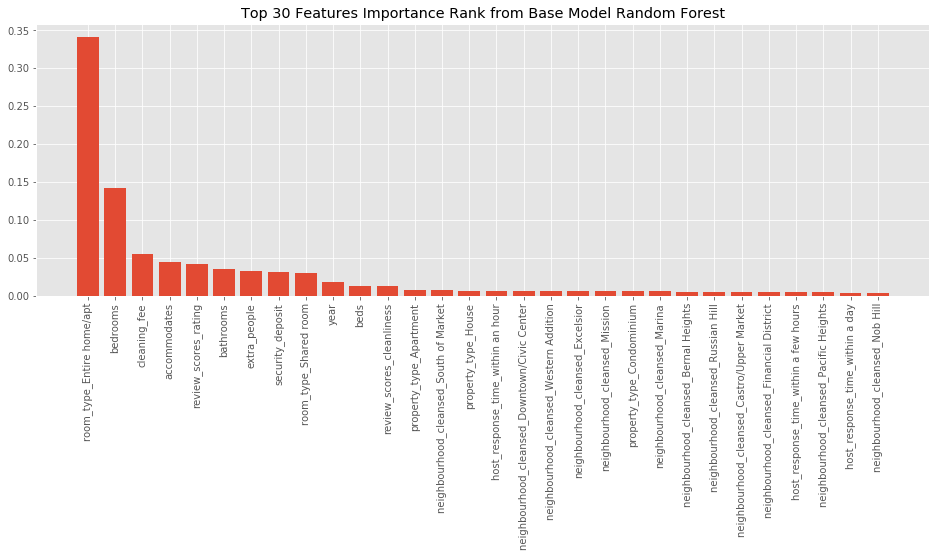

In [193]:
rf_features = X_train.columns
rf_feature_imp = model.feature_importances_
feat_df = pd.DataFrame(rf_feature_imp, index=rf_features, 
                       columns=['weight']).sort_values('weight',ascending=False)[:30]
plt.figure(figsize=(16,5))
plt.bar(x=feat_df.index, height=feat_df['weight'])
plt.xticks(rotation=90)
plt.title('Top 30 Features Importance Rank from Base Model Random Forest')
plt.show()
# plt.savefig('Graphs/Feature_imp_BaseModel_RF.png', dpi = 300)

In [129]:
estimator = GradientBoostingRegressor()
model = estimator.fit(X_train,y_train)
preds = model.predict(X_val)
r2 = model.score(X_val, y_val)
rmse = mean_squared_error(preds, y_val)
cs_val = cross_val_score(estimator, X_train, y_train, cv=3)
print(f'R2: {r2}, RMSE: {np.exp(rmse)},\nCross Val Scores: {cs_val}')

R2: 0.658990219990894, RMSE: 1.1771909124944477,
Cross Val Scores: [0.65703414 0.65983513 0.65308465]
 [0.63178795 0.63686895 0.65681899]


## Train Test Split Option 2: Randomized test group

In [238]:
train_df2, test = train_test_split(sf_df, test_size = 0.3)

In [239]:
#Filling the NaNs in beds, bathrooms, bedrooms
#Assume that if the tenant has the full apartment, they have a bathroom/bedroom
cond1= (train_df2['room_type']=='Entire home/apt')
train_df2.loc[cond1 & (train_df2['beds']==0), train_df2.columns=='beds'] = 1
train_df2.loc[cond1 & (train_df2['bathrooms']==0), train_df2.columns=='bathrooms']
#For the rest, just fill na
train_df2[['beds','bathrooms', 'bedrooms']] = train_df2[['beds','bathrooms', 'bedrooms']].fillna(0)

#For review scores, let's just fillin with the average
review_lst = ['review_scores_accuracy', 'review_scores_checkin',
       'review_scores_cleanliness', 'review_scores_communication',
       'review_scores_location', 'review_scores_rating', 'review_scores_value']
for review in review_lst:
    train_df2[review] = train_df2[review].fillna(train_df2[review].mean())

/Users/sherryduong/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/sherryduong/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3494: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/sherryduong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

In [216]:
features=['accommodates','bathrooms', 'bed_type','bedrooms', 'beds','cleaning_fee',
          'extra_people', 'host_response_time',
         'neighbourhood_cleansed','property_type','review_scores_cleanliness',
          'review_scores_rating', 'room_type', 'security_deposit', 'month','day_of_week', 'year']
X = train_df2[features]
y = train_df2['price'].apply(np.log)

X = pd.get_dummies(X, columns=['bed_type','host_response_time', 
                           'neighbourhood_cleansed','property_type',
                           'room_type','month','day_of_week'])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3)

In [144]:
X_train.isnull().sum().sort_values(ascending=False)

day_of_week_6                       0
day_of_week_5                       0
neighbourhood_cleansed_Lakeshore    0
neighbourhood_cleansed_Marina       0
neighbourhood_cleansed_Mission      0
                                   ..
property_type_Loft                  0
property_type_Other                 0
property_type_Pension (Korea)       0
property_type_Plane                 0
accommodates                        0
Length: 128, dtype: int64

In [145]:
estimator = LinearRegression()
model = estimator.fit(X_train,y_train)
preds = model.predict(X_val)
r2 = model.score(X_val, y_val)
rmse = mean_squared_error(preds, y_val)
cs_val = cross_val_score(estimator, X_train, y_train, cv=3)
print(f'R2: {r2}, RMSE: {np.exp(rmse)},\nCross Val Scores: {cs_val}')

R2: 0.6195407865471894, RMSE: 1.1990357758826116,
Cross Val Scores: [0.61448009 0.6125702  0.61408478]


In [146]:
estimator = DecisionTreeRegressor()
model = estimator.fit(X_train,y_train)
preds = model.predict(X_val)
r2 = model.score(X_val, y_val)
rmse = mean_squared_error(preds, y_val)
cs_val = cross_val_score(estimator, X_train, y_train, cv=3)
print(f'R2: {r2}, RMSE: {np.exp(rmse)},\nCross Val Scores: {cs_val}')

R2: 0.8384910281682455, RMSE: 1.0801027709707502,
Cross Val Scores: [0.78461513 0.78372372 0.78913265]


In [240]:
estimator = RandomForestRegressor()
model = estimator.fit(X_train,y_train)
preds = model.predict(X_val)
r2 = model.score(X_val, y_val)
rmse = mean_squared_error(preds, y_val)
cs_val = cross_val_score(estimator, X_train, y_train, cv=3)
cs_val2 = cross_val_score(estimator, X_train, y_train, cv=3)
print(f'R2: {r2}, RMSE: {np.exp(rmse)},\nCross Val Score: {np.mean(cs_val),np.mean(cs_val2)}')

/Users/sherryduong/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



R2: 0.8437661589999108, RMSE: 1.0776812617268874,
Cross Val Score: (0.8211363320812796, 0.8202737140035001)


In [219]:
print(f'R2: {r2}, RMSE: {np.exp(rmse)},\nCross Val Score: {np.mean(cs_val)}')

R2: 0.8860908403623582, RMSE: 1.0559567144022552,
Cross Val Score: 0.8606275566591085


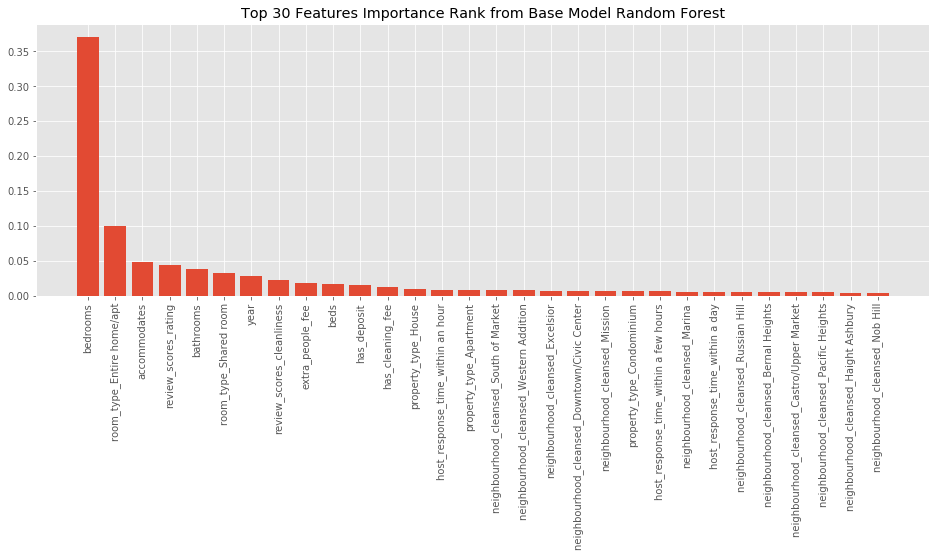

In [242]:
rf_features = X_train.columns
rf_feature_imp = model.feature_importances_
feat_df = pd.DataFrame(rf_feature_imp, index=rf_features, 
                       columns=['weight']).sort_values('weight',ascending=False)[:30]
plt.figure(figsize=(16,5))
plt.bar(x=feat_df.index, height=feat_df['weight'])
plt.xticks(rotation=90)
plt.title('Top 30 Features Importance Rank from Base Model Random Forest')
plt.savefig('Graphs/Feature_imp_BaseModel_RF.png', dpi = 300)
plt.show()

In [148]:
estimator = GradientBoostingRegressor()
model = estimator.fit(X_train,y_train)
preds = model.predict(X_val)
r2 = model.score(X_val, y_val)
rmse = mean_squared_error(preds, y_val)
cs_val = cross_val_score(estimator, X_train, y_train, cv=3)
print(f'R2: {r2}, RMSE: {np.exp(rmse)},\nCross Val Score: {np.mean(cs_val)}')

R2: 0.6548550123321404, RMSE: 1.179003085683084,
Cross Val Scores: [0.64890508 0.64562447 0.64980722]


## Model Iteration #1: Fee columns (Y or N) with random split

In [235]:
train_df2, test = train_test_split(sf_df, test_size = 0.3)

In [236]:
#Filling the NaNs in beds, bathrooms, bedrooms
#Assume that if the tenant has the full apartment, they have a bathroom/bedroom
cond1= (train_df2['room_type']=='Entire home/apt')
train_df2.loc[cond1 & (train_df2['beds']==0), train_df2.columns=='beds'] = 1
train_df2.loc[cond1 & (train_df2['bathrooms']==0), train_df2.columns=='bathrooms']
#For the rest, just fill na
train_df2[['beds','bathrooms', 'bedrooms']] = train_df2[['beds','bathrooms', 'bedrooms']].fillna(0)

#For review scores, let's just fillin with the average
review_lst = ['review_scores_accuracy', 'review_scores_checkin',
       'review_scores_cleanliness', 'review_scores_communication',
       'review_scores_location', 'review_scores_rating', 'review_scores_value']
for review in review_lst:
    train_df2[review] = train_df2[review].fillna(train_df2[review].mean())

/Users/sherryduong/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/sherryduong/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3494: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/sherryduong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

In [223]:
cols = ['has_deposit','has_cleaning_fee','extra_people_fee']

train_df2['has_deposit'] = train_df2['security_deposit'].transform(lambda x: 1 if x>0 else 0)
train_df2['has_cleaning_fee'] = train_df2['cleaning_fee'].transform(lambda x: 1 if x>0 else 0)
train_df2['extra_people_fee'] = train_df2['extra_people'].transform(lambda x: 1 if x>0 else 0)

/Users/sherryduong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/sherryduong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/sherryduong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

In [224]:
features=['accommodates','bathrooms', 'bed_type','bedrooms', 'beds','cleaning_fee',
          'extra_people', 'host_response_time','neighbourhood_cleansed','property_type','review_scores_cleanliness',
          'review_scores_rating', 'room_type', 'security_deposit', 'month','day_of_week', 'year',
          'has_cleaning_fee','has_deposit','extra_people_fee']
X = train_df2[features]
y = train_df2['price'].apply(np.log)

X = pd.get_dummies(X, columns=['bed_type','host_response_time', 
                           'neighbourhood_cleansed','property_type',
                           'room_type','month','day_of_week'])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3)

In [237]:
estimator = RandomForestRegressor()
model = estimator.fit(X_train,y_train)
preds = model.predict(X_val)
r2 = model.score(X_val, y_val)
rmse = mean_squared_error(preds, y_val)
cs_val = cross_val_score(estimator, X_train, y_train, cv=3)
cs_val2 = cross_val_score(estimator, X, y, cv=3)
print(f'R2: {r2}, RMSE: {np.exp(rmse)},\nTrain Cross Val Score: {np.mean(cs_val)}, Validation Cross Val Score: {np.mean(cs_val2)}')

/Users/sherryduong/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



R2: 0.8419752258289215, RMSE: 1.0786058548705062,
Train Cross Val Score: 0.8218449632057027, Validation Cross Val Score: 0.8418387285304645


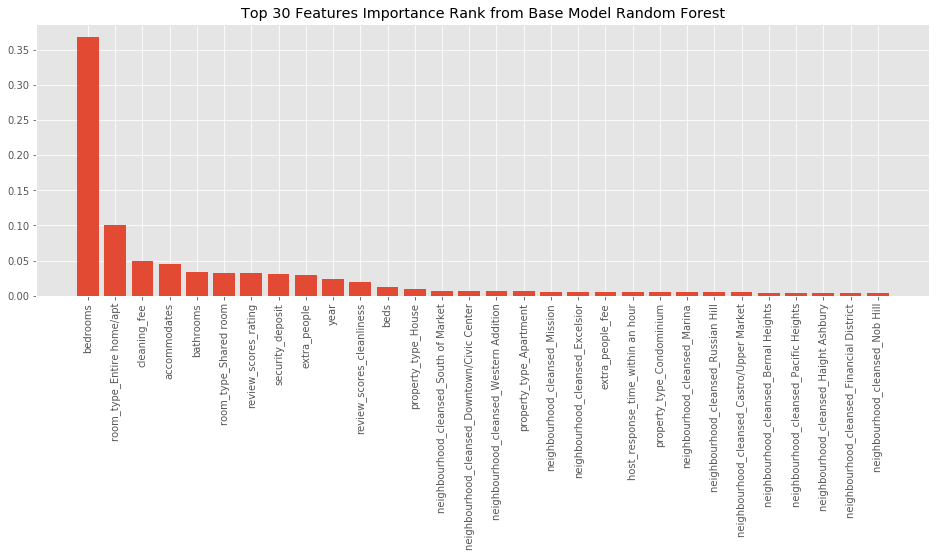

In [226]:
rf_features = X_train.columns
rf_feature_imp = model.feature_importances_
feat_df = pd.DataFrame(rf_feature_imp, index=rf_features, 
                       columns=['weight']).sort_values('weight',ascending=False)[:30]
plt.figure(figsize=(16,5))
plt.bar(x=feat_df.index, height=feat_df['weight'])
plt.xticks(rotation=90)
plt.title('Top 30 Features Importance Rank from Base Model Random Forest')
plt.show()

In [227]:
#Keep only Y or N column, remove the previous columns
features=['accommodates','bathrooms', 'bed_type','bedrooms', 'beds', 'host_response_time','neighbourhood_cleansed','property_type','review_scores_cleanliness',
          'review_scores_rating', 'room_type', 'month','day_of_week', 'year',
          'has_cleaning_fee','has_deposit','extra_people_fee']
X = train_df2[features]
y = train_df2['price'].apply(np.log)

X = pd.get_dummies(X, columns=['bed_type','host_response_time', 
                           'neighbourhood_cleansed','property_type',
                           'room_type','month','day_of_week'])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3)

In [231]:
estimator = LinearRegression()
model = estimator.fit(X_train,y_train)
preds = model.predict(X_val)
r2 = model.score(X_val, y_val)
rmse = mean_squared_error(preds, y_val)
cs_val = cross_val_score(estimator, X_train, y_train, cv=3)
print(f'R2: {r2}, RMSE: {np.exp(rmse)},\nCross Val Scores: {np.mean(cs_val)}')

R2: 0.6168595194328593, RMSE: 1.2013726815493564,
Cross Val Scores: 0.6162455854225947


In [232]:
estimator = DecisionTreeRegressor()
model = estimator.fit(X_train,y_train)
preds = model.predict(X_val)
r2 = model.score(X_val, y_val)
rmse = mean_squared_error(preds, y_val)
cs_val = cross_val_score(estimator, X_train, y_train, cv=3)
print(f'R2: {r2}, RMSE: {np.exp(rmse)},\nCross Val Scores: {np.mean(cs_val)}')

R2: 0.7662293106653874, RMSE: 1.1184456012053547,
Cross Val Scores: 0.727698755737018


In [234]:
estimator = RandomForestRegressor()
model = estimator.fit(X_train,y_train)
preds = model.predict(X_val)
r2 = model.score(X_val, y_val)
rmse = mean_squared_error(preds, y_val)
cs_val = cross_val_score(estimator, X_train, y_train, cv=3)
cs_val2 = cross_val_score(estimator, X, y, cv=3)
print(f'R2: {r2}, RMSE: {np.exp(rmse)},\nTrain Cross Val Score: {np.mean(cs_val)}, Validation Cross Val Score: {np.mean(cs_val2)}')

/Users/sherryduong/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



R2: 0.8443779587985024, RMSE: 1.0773655935730009,
Train Cross Val Score: 0.8206920003521495, Validation Cross Val Score: 0.8416929050647911


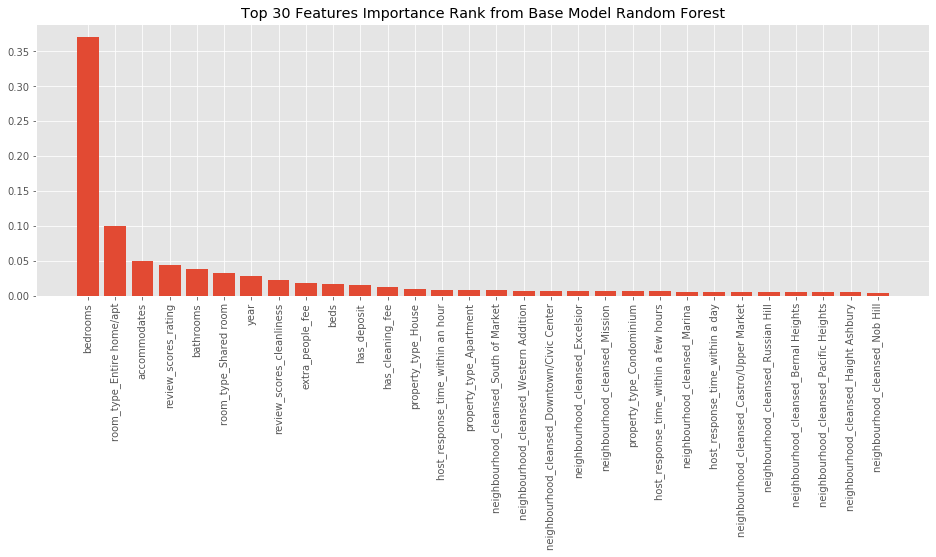

In [229]:
rf_features = X_train.columns
rf_feature_imp = model.feature_importances_
feat_df = pd.DataFrame(rf_feature_imp, index=rf_features, 
                       columns=['weight']).sort_values('weight',ascending=False)[:30]
plt.figure(figsize=(16,5))
plt.bar(x=feat_df.index, height=feat_df['weight'])
plt.xticks(rotation=90)
plt.title('Top 30 Features Importance Rank from Base Model Random Forest')
plt.show()

In [233]:
estimator = GradientBoostingRegressor()
model = estimator.fit(X_train,y_train)
preds = model.predict(X_val)
r2 = model.score(X_val, y_val)
rmse = mean_squared_error(preds, y_val)
cs_val = cross_val_score(estimator, X_train, y_train, cv=3)
print(f'R2: {r2}, RMSE: {np.exp(rmse)},\nCross Val Score: {np.mean(cs_val)}')

R2: 0.6403964514015622, RMSE: 1.1879085836939862,
Cross Val Score: 0.6389511540880118
